# INM702 Coursework - Task 2

Dataset retrieved from:
https://www.kaggle.com/datasets/robertmifsud/resized-reduced-gz2-images

Full and additional references are included in the report

In [1]:
import os    
os.environ["KMP_DUPLICATE_LIB_OK"] = "True" #Kernal would repeatedly die when using matplotlib unless this line was used

%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from datetime import datetime
import time

## Check whether to use GPU or CPU

In [2]:
if torch.cuda.is_available():
    
    device = torch.device("cuda")
    
else:
    
    device = torch.device("cpu")
    
print("Device:", device)

Device: cuda


## Loading train and test data

In [3]:
# Training for this model was done using the reduced_dataset_size folder
# Please use this folder if you would like to achieve similar results to my tests
train_path = r"archive\reduced_dataset_size\images_E_S_SB_69x69_a_03\images_E_S_SB_69x69_a_03_train"
test_path = r"archive\reduced_dataset_size\images_E_S_SB_69x69_a_03\images_E_S_SB_69x69_a_03_test"

dataset = ImageFolder(train_path, transform = transforms.Compose([transforms.Resize((69,69)),transforms.ToTensor()]))

test_dataset = ImageFolder(test_path, transforms.Compose([transforms.Resize((69,69)),transforms.ToTensor()]))

img, label = dataset[0]

print(img.shape,label)
print("Classes: \n",dataset.classes)

torch.Size([3, 69, 69]) 0
Classes: 
 ['E', 'S', 'SB']


## Display sample image to confirm data was loaded correctly

Label : E


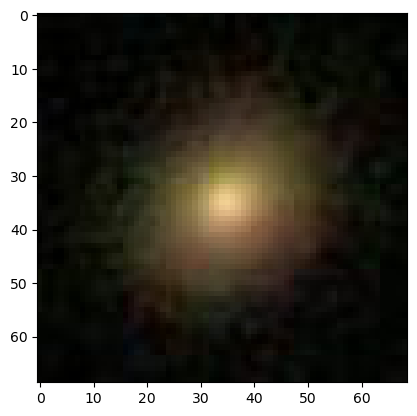

In [4]:
def display_image(img, label):
    
    print(f"Label : {dataset.classes[label]}")
    
    plt.imshow(img.permute(1,2,0))

display_image(*dataset[0])

## Split train data into training and validation sets

In [5]:
valid_size = int(len(dataset) * 0.2)
train_size = len(dataset) - valid_size 

train_data, valid_data = random_split(dataset, [train_size, valid_size])

print("Train Data:", len(train_data))
print("Validation Data:",  len(valid_data))

Train Data: 22188
Validation Data: 5546


## Generate batches for training, validation and test sets

In [6]:
batch_size = 64

train_batches = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_batches = DataLoader(valid_data, batch_size * 2, num_workers = 2, pin_memory = True)
test_batches = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

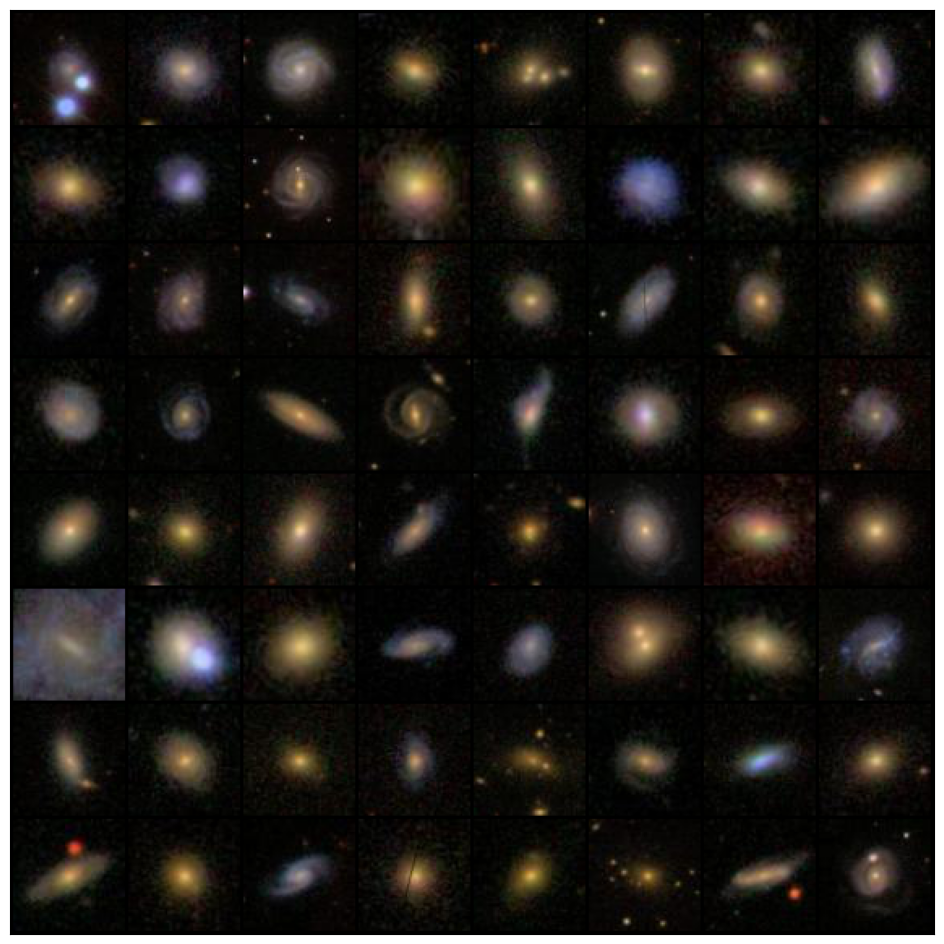

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(batch):
    
    for images, labels in batch:
        fig,ax = plt.subplots(figsize = (16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break
        
show_batch(train_batches)

## Neural Network Class

In [8]:
class ImageNeuralNetwork(nn.Module):
    
    def __init__(self, learning_rate = 0.1, epochs = 5):
        
        super().__init__()
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # VGG16 Architecture
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = 0.9),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = 0.9),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = 0.9),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = 0.9),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            
            nn.Dropout(0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            nn.Linear(4096, 3),
            nn.LogSoftmax(dim = 1)

        )
        
        # LeNet Architecture
        """self.network = nn.Sequential(
            
            #Optimal kernal size (3, 3)
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            
            nn.Linear(18496, 256),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 3),
            nn.LogSoftmax(dim = 1)

        )"""

    # Perform a forward pass through the initialised network
    def forward(self, x):
        
        return self.network(x)
    
    # Determine the accuracy of the predicted output
    def accuracy(self, outputs, labels):
        
        a, predictions = torch.max(outputs, dim = 1)
        
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    # Sets the model's optimiser to the input provided
    def set_optimiser(self, optimiser):
        
        self.optimiser = optimiser

    # Calculates the accuracy and loss values for a set of given test batch
    @torch.no_grad() #Updates weights without calculating gradients during evaluation
    def evaluate(self, model, valid_batches):
        
        model.eval()
        outputs = []
        
        for batch in valid_batches:
            
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)
            
            predictions = model(images)
            loss = F.cross_entropy(predictions, labels)
            accuracy = self.accuracy(predictions, labels)
            
            outputs.append({"valid_loss": loss.detach(), "valid_accuracy": accuracy})
    
        #Combine losses and accuracies
        batch_loss = [x["valid_loss"] for x in outputs]
        batch_accuracy = [x["valid_accuracy"] for x in outputs]
        
        epoch_loss = torch.stack(batch_loss).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        
        return {"valid_loss": epoch_loss.item(), "valid_accuracy": epoch_accuracy.item()}
    
    # Train the model based on the training and validation batches provided
    def fit(self, model, train_batches, valid_batches):
    
        history = []

        for epoch in range(self.epochs):
            
            start = datetime.now()
            
            model.train()
            train_losses = []
            train_accuracies = []

            for batch in train_batches:

                images, labels = batch 
                images, labels = images.to(device), labels.to(device)
                
                predictions = model(images)
                loss = F.cross_entropy(predictions, labels)
                accuracy = self.accuracy(predictions, labels)
                
                train_losses.append(loss)
                train_accuracies.append(accuracy)
                
                loss.backward()
                
                self.optimiser.step()
                self.optimiser.zero_grad()

            result = self.evaluate(model, valid_batches)
            result["train_loss"] = torch.stack(train_losses).mean().item()
            result["train_accuracy"] = torch.stack(train_accuracies).mean().item()
            
            print("Epoch [{}], train_loss: {:.4f}, valid_loss: {:.4f}, train_accuracy: {:.4f}, valid_accuracy: {:.4f}".format(
                epoch, result["train_loss"], result["valid_loss"], result["train_accuracy"], result["valid_accuracy"]))
            print(f"Time taken for epoch {epoch}: {datetime.now()-start}")
            
            history.append(result)

        return history

## Initialise model and set hyperparameters

In [9]:
learning_rate = 0.0001
epochs = 5

model = ImageNeuralNetwork(learning_rate, epochs)

#optimiser = torch.optim.SGD(model.parameters(), learning_rate, momentum = 0.9, weight_decay = 0.005)
optimiser = torch.optim.Adam(model.parameters(), learning_rate, weight_decay = 0.00001)

model.set_optimiser(optimiser)

print(model)

ImageNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1

## Fit model and get recorded loss values of each epoch

In [10]:
model.to(device)

history = model.fit(model, train_batches, valid_batches)

Epoch [0], train_loss: 0.8855, valid_loss: 0.8081, train_accuracy: 0.5837, valid_accuracy: 0.6384
Time taken for epoch 0: 0:01:12.831502
Epoch [1], train_loss: 0.7469, valid_loss: 0.7573, train_accuracy: 0.6659, valid_accuracy: 0.6491
Time taken for epoch 1: 0:01:05.542721
Epoch [2], train_loss: 0.6641, valid_loss: 0.6405, train_accuracy: 0.7058, valid_accuracy: 0.7233
Time taken for epoch 2: 0:01:05.750664
Epoch [3], train_loss: 0.6250, valid_loss: 0.6377, train_accuracy: 0.7260, valid_accuracy: 0.7348
Time taken for epoch 3: 0:01:05.610800
Epoch [4], train_loss: 0.6035, valid_loss: 0.6038, train_accuracy: 0.7391, valid_accuracy: 0.7420
Time taken for epoch 4: 0:01:05.728924


## Test model with test set

In [11]:
prediction = model.evaluate(model, test_batches)

In [12]:
print("valid_loss: {:.4f}, valid_accuracy: {:.4f}".format(prediction["valid_loss"], prediction["valid_accuracy"]))

valid_loss: 0.5344, valid_accuracy: 0.8028


## Plot train and validation loss and accuracy

In [13]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


for idx in range(len(history)):
    
    train_losses.append(history[idx]["train_loss"])
    train_accuracies.append(history[idx]["train_accuracy"])
    valid_losses.append(history[idx]["valid_loss"])
    valid_accuracies.append(history[idx]["valid_accuracy"])

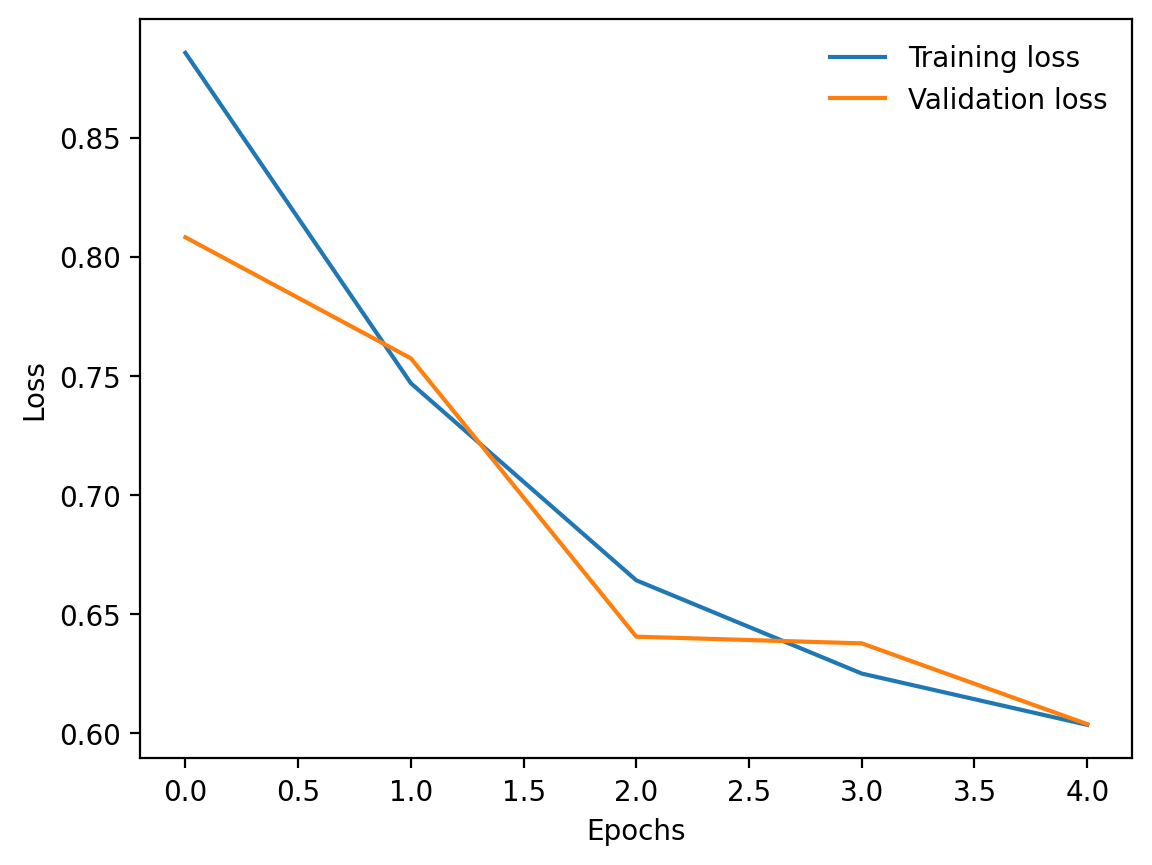

In [16]:
%config InlineBackend.figure_format = "retina"

plt.plot(train_losses, label = "Training loss")
plt.plot(valid_losses, label = "Validation loss")
plt.title("Average loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon = False)
plt.show()

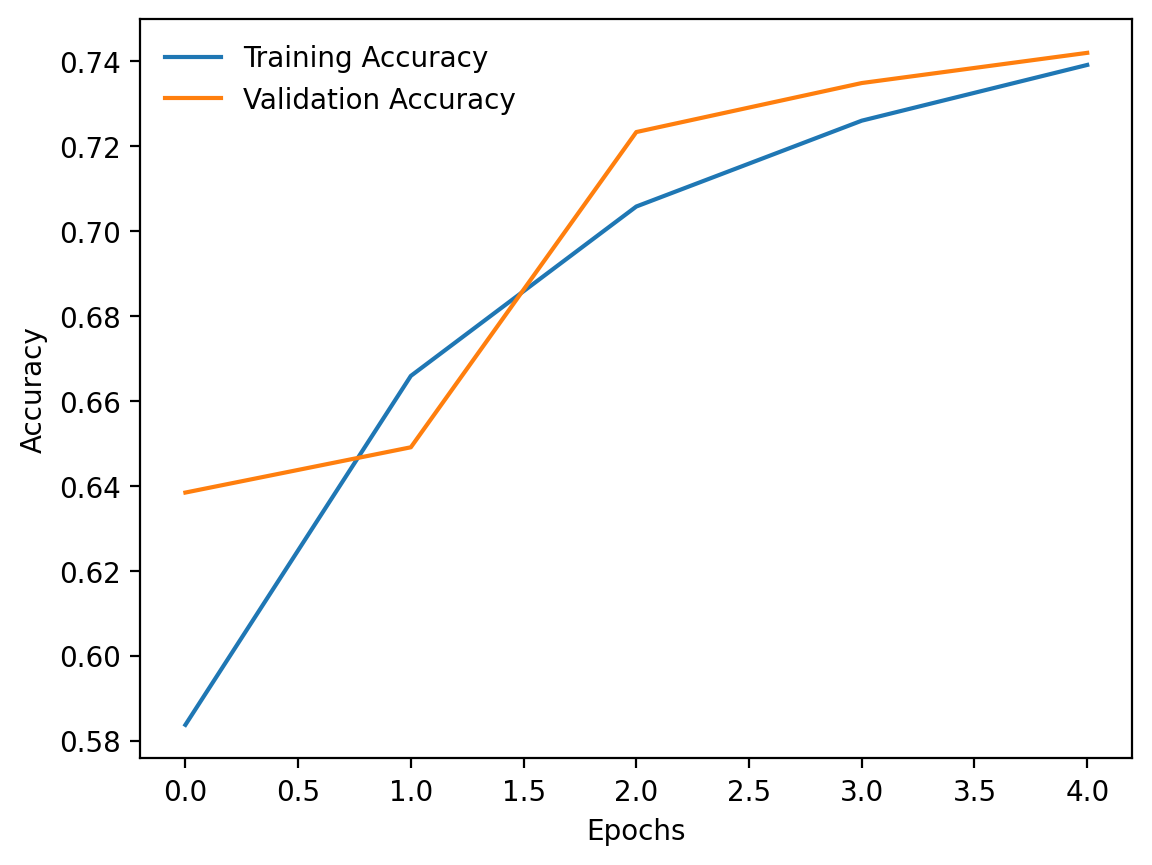

In [17]:
%config InlineBackend.figure_format = "retina"

plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Average accuracy per epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon = False)
plt.show()